<a href="https://colab.research.google.com/github/cylyu/ist718-project/blob/main/Colab_Data_Loading_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example Project Notebook

## SB718

There are only 2 accepted ways to load data for your project, from a cloud service or Google drive.  If you load data from a cloud service like github, you don't have to follow this format. Keep in mind that the graders do not expect to have to perform any manual steps to load your data from a cloud service.  If we don't see these cells at the start of your notebook, we will assume you are loading your data from a cloud service.<br>
If you are loading data through Google drive, the following cells must be at the start of your notebook.  The naming scheme that we are requiring teams to use will allow us to run your code without having to modify your code.

In [1]:
# The first code cell of your notebook shall include all needed imports to run your project code.  Note that
# there can be markdown cells above this cell.
import pandas as pd

In [2]:
# # All data files shall be located in the following directory on 
# # your google drive: /content/drive/My Drive/ist718_data/data_groupN

# # The following provides 2 example file names and their full path names.  This example assumes the assigned
# # group name is group12.  The definitions in this cell must be used to load all data files.
# # This is only an example, change these definitions to match your file names.
# car_data_csv = '/content/drive/My Drive/ist718_data/data_group12/car_data.csv'
# engine_data_csv = '/content/drive/My Drive/ist718_data/data_group12/engine_data.csv'

In [3]:
# # The third code cell of your notebook must contain code to mount your google drive and load the data files
# from google.colab import drive
# drive.mount('/content/drive')

# # You must use the definitions above to load your data.
# car_df = pd.read_csv(car_data_csv)
# engine_df = pd.read_csv(engine_data_csv)

In [4]:
# Other code or markdown cells follow ...


In [5]:
! git clone https://github.com/cylyu/ist718-project.git

Cloning into 'ist718-project'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 27 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (27/27), done.


In [6]:
! ls

ist718-project	nyc-rolling-sales.csv  sample_data


## nb 718

In [7]:
%%bash
pip install pyspark
# Download tweets.csv from github
# If the tweets.csv file does not exist in the colab environment
if [[ ! -f ./nyc-rolling-sales.csv ]]; then 
   # download tweets.csv file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/cylyu/ist718-project/main/nyc-rolling-sales.csv   
fi

# vefify tweets.csv exits in the colab env - should not print an error message
ls nyc-rolling-sales.csv

nyc-rolling-sales.csv


In [8]:
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.sql import functions as fn
from pyspark.sql import types
from pyspark.sql.functions import *
from pyspark.sql.functions import from_utc_timestamp
from pyspark.sql import SQLContext
from pyspark.sql.functions import col,lower
import numpy as np
from pyspark.ml.feature import VectorAssembler
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
from pyspark.ml.feature import StandardScaler,PCA,OneHotEncoder
from pyspark.sql.functions import concat, concat_ws
import pandas as pd
from pyspark.sql.types import DoubleType,IntegerType,TimestampType,DateType, StringType,LongType
spark = SparkSession.builder.master("local[*]").config("spark.memory.fraction", 0.8).config("spark.executor.memory", "12g").config("spark.driver.memory", "12g").config("spark.memory.offHeap.enabled",'true').config("spark.memory.offHeap.size","12g").getOrCreate()
sparkContext=spark.sparkContext
from pyspark.sql.functions import year, month, dayofmonth

In [9]:

nyc_rolling_sales_df = spark.read.csv("nyc-rolling-sales.csv", header=True, inferSchema=True)

In [10]:
dup_row=nyc_rolling_sales_df\
    .groupby(['ADDRESS', 'NEIGHBORHOOD','SALE DATE','SALE PRICE']) \
    .count() \
    .where('count > 1') \
    .sort('count', ascending=False)

def sum_col(df, col):
    return df.select(fn.sum(col)).collect()[0][0]


print('number of duplicate rows: ',sum_col(dup_row,'count'),\
      'distinct rows of duplicate: ',dup_row.count(),'row needs to delete: ',sum_col(dup_row,'count')-dup_row.count())

number of duplicate rows:  3748 distinct rows of duplicate:  1225 row needs to delete:  2523


In [96]:
#drop duplicate row 
nyc_rolling_sales_df=nyc_rolling_sales_df.drop_duplicates(subset=['ADDRESS', 'NEIGHBORHOOD','SALE DATE'])


## clyu

In [97]:
#rename the column
df3=nyc_rolling_sales_df.withColumnRenamed('APARTMENT NUMBER','apartment_number').withColumnRenamed('SALE PRICE','sale_price').\
withColumnRenamed('SALE DATE','sale_date').\
withColumnRenamed('BUILDING CLASS AT TIME OF SALE','building_class_at_sale').\
withColumnRenamed('ZIP CODE','zipcode').\
withColumnRenamed('GROSS SQUARE FEET','gross_square_feet').\
withColumnRenamed('LAND SQUARE FEET','land_square_feet').\
withColumnRenamed('BOROUGH','borough')
df3.show(5)

+-----+-------+--------------+-----------------------+--------------------+-----+----+---------+-------------------------+--------------------+----------------+-------+-----------------+----------------+-----------+----------------+-----------------+----------+-------------------------+----------------------+----------+-------------------+
|  _c0|borough|  NEIGHBORHOOD|BUILDING CLASS CATEGORY|TAX CLASS AT PRESENT|BLOCK| LOT|EASE-MENT|BUILDING CLASS AT PRESENT|             ADDRESS|apartment_number|zipcode|RESIDENTIAL UNITS|COMMERCIAL UNITS|TOTAL UNITS|land_square_feet|gross_square_feet|YEAR BUILT|TAX CLASS AT TIME OF SALE|building_class_at_sale|sale_price|          sale_date|
+-----+-------+--------------+-----------------------+--------------------+-----+----+---------+-------------------------+--------------------+----------------+-------+-----------------+----------------+-----------+----------------+-----------------+----------+-------------------------+----------------------+------

In [98]:
df3=df3.withColumn('building_age', 2020-col('YEAR BUILT')).drop("YEAR BUILT").filter(df3.sale_price != ' -  ').\
                      filter(df3.land_square_feet != ' -  ').\
                      filter(df3.gross_square_feet != ' -  ').\
         withColumn("sale_price",df3["sale_price"].cast(IntegerType())).\
         withColumn("gross_square_feet",df3["gross_square_feet"].cast(IntegerType())).\
         withColumn("sale_date",df3["sale_date"].cast(DateType())).\
         withColumn("land_square_feet",df3["land_square_feet"].cast(IntegerType())).\
         withColumn("price_per_sq_ft", col("sale_price") / col("gross_square_feet")).\
         withColumn('borough',fn.when(fn.col('borough')==1,'Manhatten').\
                                                     when(fn.col('borough')==2,'Bronx').\
                                                     when(fn.col('borough')==3,'Brooklyn').\
                                                     when(fn.col('borough')==4,'Queens').\
                                                     when(fn.col('borough')==5,'Staten Island').\
                                                     otherwise(fn.col("borough"))).where('sale_price != 0')


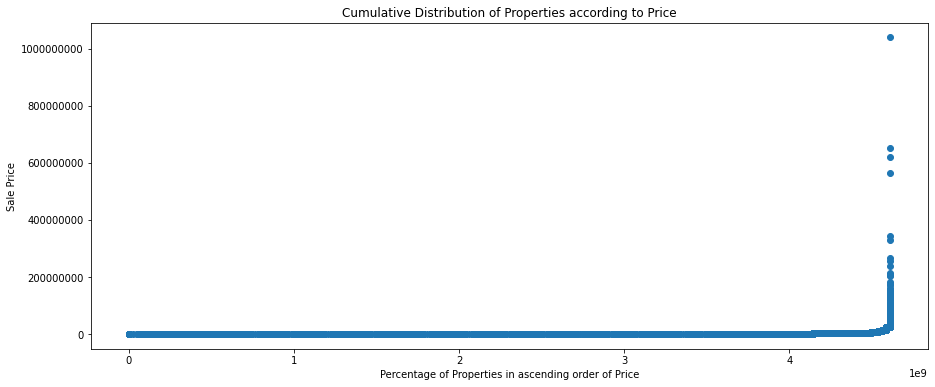

In [100]:
#Set the size of the plot
plt.figure(figsize=(15,6))

from pyspark.sql.functions import monotonically_increasing_id 






#Get the data and format it
x = df3.select('sale_price').sort('sale_price')
df_index = x.select("*").withColumn("id", monotonically_increasing_id())

total_index=df_index.count()
price_pro=df_index.withColumn("property proportion",(col("id") +1)*100/total_index)
price_pro_pd=price_pro.toPandas()


# Plot the data and configure the settings
plt.plot(price_pro_pd['property proportion'],price_pro_pd['sale_price'], linestyle='None', marker='o')
plt.title('Cumulative Distribution of Properties according to Price')
plt.xlabel('Percentage of Properties in ascending order of Price')
plt.ylabel('Sale Price')
plt.ticklabel_format(style='plain', axis='y')
plt.show()


In [108]:
df3= df3.where(df3.sale_price > 100000).where(df3.sale_price < 100000000)

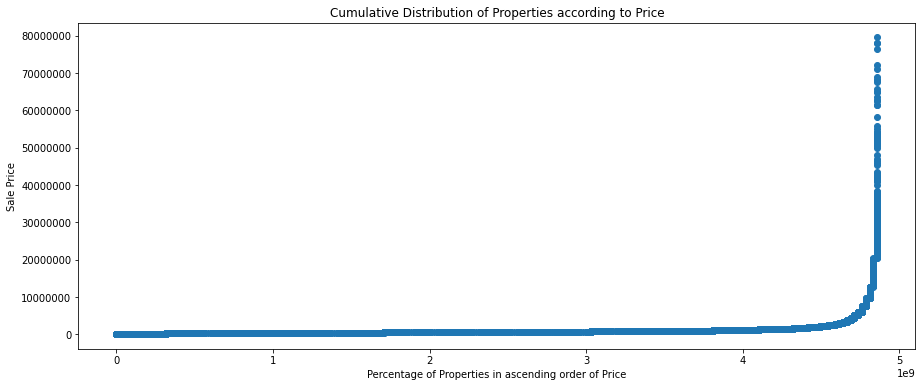

In [109]:
#Set the size of the plot
plt.figure(figsize=(15,6))

from pyspark.sql.functions import monotonically_increasing_id 






#Get the data and format it
x = df3.select('sale_price').sort('sale_price')
df_index = x.select("*").withColumn("id", monotonically_increasing_id())

total_index=df_index.count()
price_pro=df_index.withColumn("property proportion",(col("id") +1)*100/total_index)
price_pro_pd=price_pro.toPandas()


# Plot the data and configure the settings
plt.plot(price_pro_pd['property proportion'],price_pro_pd['sale_price'], linestyle='None', marker='o')
plt.title('Cumulative Distribution of Properties according to Price')
plt.xlabel('Percentage of Properties in ascending order of Price')
plt.ylabel('Sale Price')
plt.ticklabel_format(style='plain', axis='y')
plt.show()


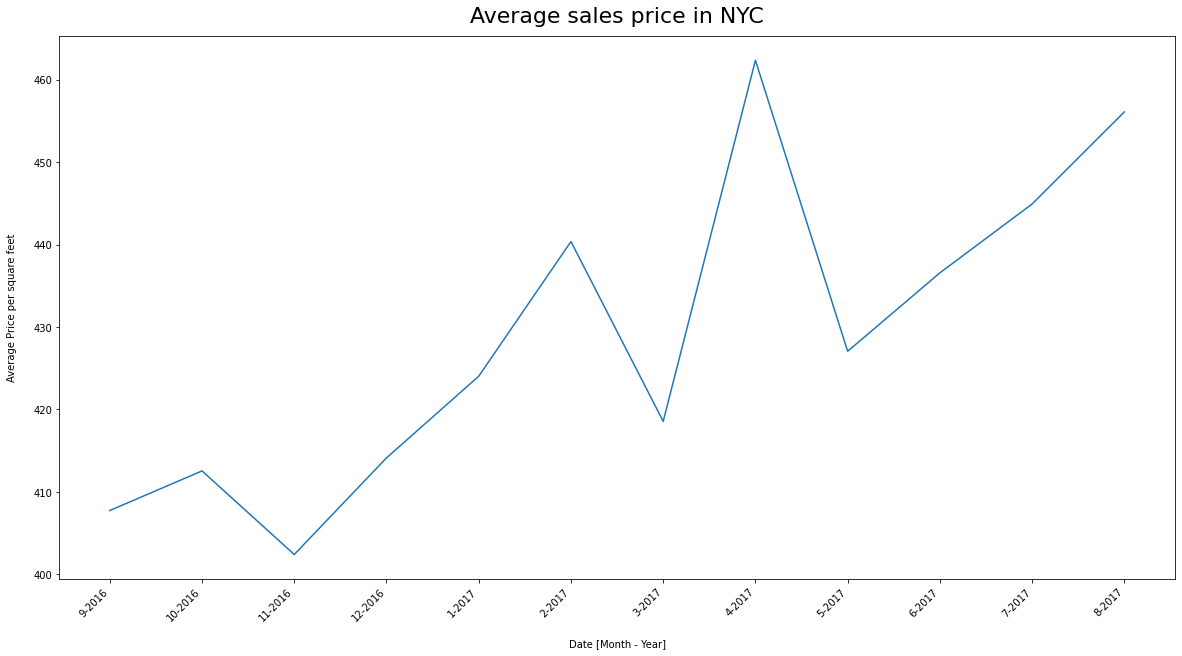

In [115]:










date_df=df3.select("sale_date",
                                    "price_per_sq_ft",
    year("sale_date").alias('year'), 
    month("sale_date").alias('month'), 
    dayofmonth("sale_date").alias('day')
)

                                                
b=date_df.groupBy('month','year').avg('price_per_sq_ft')
b=b.withColumn("month_year", concat_ws("-",  b.month,b.year))
b_pd=b.sort('year', 'month').toPandas()
names = b_pd['month_year']
values =b_pd['avg(price_per_sq_ft)']

fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(names, values)
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
)
plt.ylabel("Average Price per square feet", labelpad=16)

plt.xlabel("Date [Month - Year]", labelpad=16)
plt.title("Average sales price in NYC", y=1.013, fontsize=22)
plt.show()

In [ ]:
df = df3.where([(df['SALE PRICE'] > 100000) & (df['SALE PRICE'] < 5000000)]

In [114]:
b_pd

,month,year,avg(price_per_sq_ft),month_year
0,9,2016,407.742968,9-2016
1,10,2016,412.547419,10-2016
2,11,2016,402.409160,11-2016
3,12,2016,414.125261,12-2016
4,1,2017,424.034239,1-2017
5,2,2017,440.368337,2-2017
6,3,2017,418.558657,3-2017
7,4,2017,462.352477,4-2017
8,5,2017,427.061855,5-2017
9,6,2017,436.571398,6-2017


In [125]:
b.orderBy(['year','month'], ascending = True).show()

+-----+----+------------------+----------+
|month|year|   avg(sale_price)|month_year|
+-----+----+------------------+----------+
|    9|2016|1059889.2241646382|    9-2016|
|   10|2016|  972787.927129751|   10-2016|
|   11|2016|1135245.6763912723|   11-2016|
|   12|2016| 1578978.440776699|   12-2016|
|    1|2017|1335039.0225330226|    1-2017|
|    2|2017| 911699.2698282911|    2-2017|
|    3|2017|1022811.9360824742|    3-2017|
|    4|2017| 953956.0300606729|    4-2017|
|    5|2017|1106589.6887243192|    5-2017|
|    6|2017| 955789.0014767932|    6-2017|
|    7|2017|1097696.9347287249|    7-2017|
|    8|2017|1093122.1405197305|    8-2017|
+-----+----+------------------+----------+



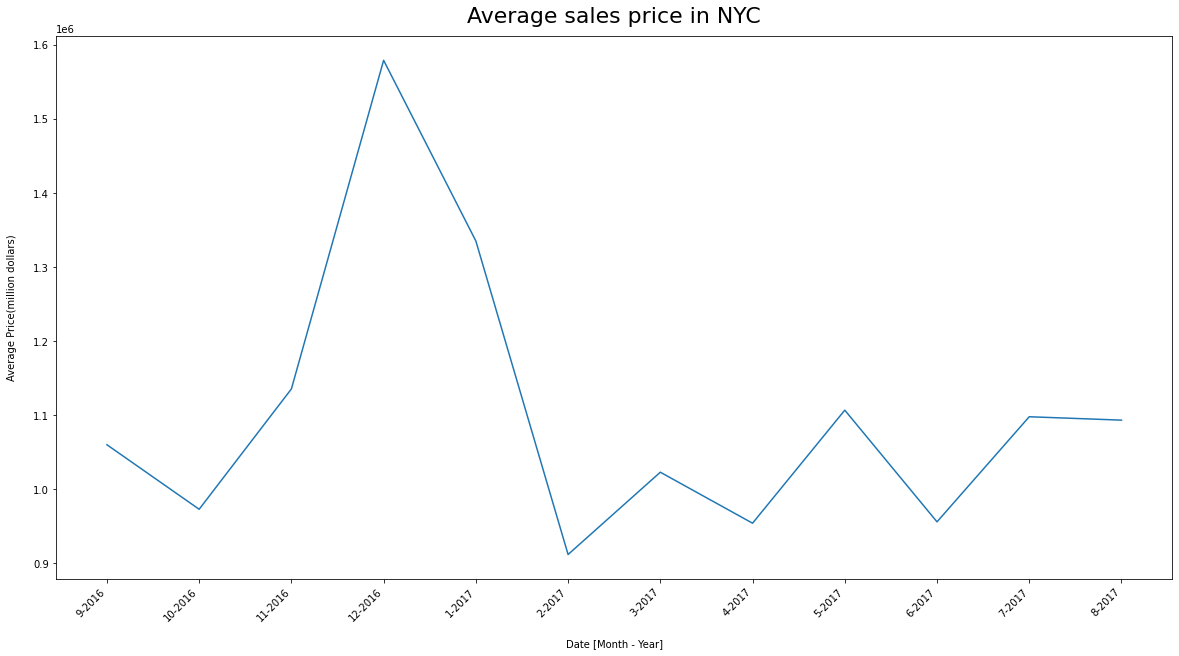

In [126]:

date_df=df3.select("sale_date",
                                    "sale_price",
    year("sale_date").alias('year'), 
    month("sale_date").alias('month'), 
    dayofmonth("sale_date").alias('day')
)
# .\
# withColumn('month',fn.when(fn.col('month')==1,'Jan').\
#                                                      when(fn.col('month')==2,'Fed').\
#                                                      when(fn.col('month')==3,'Mar').\
#                                                      when(fn.col('month')==4,'Apr').\
#                                                      when(fn.col('month')==5,'Mar').\
#                                                      when(fn.col('month')==6,'Jun').\
#                                                      when(fn.col('month')==7,'Jul').\
#                                                      when(fn.col('month')==8,'Aug').\
#                                                      when(fn.col('month')==9,'Sep').\
#                                                      when(fn.col('month')==10,'Oct').\
#                                                      when(fn.col('month')==11,'Nov').\
#                                                      when(fn.col('month')==12,'Dec').\
#                                                      otherwise(fn.col("month")))
                                                
b=date_df.groupBy('month','year').avg('sale_price')
b=b.withColumn("month_year", concat_ws("-",  b.month,b.year)).orderBy(['year','month'], ascending = True)
b_pd=b.toPandas()
names = b_pd['month_year']
values =b_pd['avg(sale_price)']

fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(names, values)
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
)
plt.ylabel("Average Price(million dollars)", labelpad=16)

plt.xlabel("Date [Month - Year]", labelpad=16)
plt.title("Average sales price in NYC", y=1.013, fontsize=22)
plt.show()


# b_pd.set_index('month_year')['avg(sale_price)'].plot(kind='line',
#                                                                                 figsize=(19, 10),
#                                                                                  color='cadetblue',
#                                                                                 rot=45)
# plt.title("Historical Count of Passengers Per Month", y=1.013, fontsize=22)
# axes= plt.axes()


In [13]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
data = [(Vectors.sparse(4, [(0, 1.0), (3, -2.0)]),),
        (Vectors.dense([4.0, 5.0, 0.0, 3.0]),),
        (Vectors.dense([6.0, 7.0, 0.0, 8.0]),),
        (Vectors.sparse(4, [(0, 9.0), (3, 1.0)]),)]
df = spark.createDataFrame(data, ["features"])

r1 = Correlation.corr(df, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

r2 = Correlation.corr(df, "features", "spearman").head()
print("Spearman correlation matrix:\n" + str(r2[0]))

Pearson correlation matrix:
DenseMatrix([[1.        , 0.05564149,        nan, 0.40047142],
             [0.05564149, 1.        ,        nan, 0.91359586],
             [       nan,        nan, 1.        ,        nan],
             [0.40047142, 0.91359586,        nan, 1.        ]])
Spearman correlation matrix:
DenseMatrix([[1.        , 0.10540926,        nan, 0.4       ],
             [0.10540926, 1.        ,        nan, 0.9486833 ],
             [       nan,        nan, 1.        ,        nan],
             [0.4       , 0.9486833 ,        nan, 1.        ]])


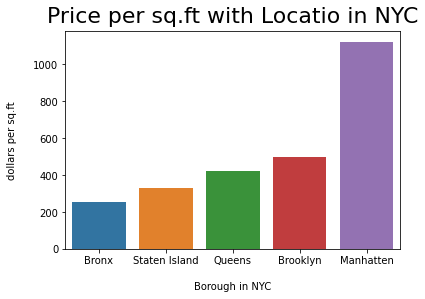

In [123]:
borough_data=df3.groupby('borough').avg('price_per_sq_ft').toPandas().sort_values('avg(price_per_sq_ft)')
sns.barplot(x = 'borough',
            y='avg(price_per_sq_ft)',
              data=borough_data
)
plt.ylabel("dollars per sq.ft", labelpad=16)

plt.xlabel("Borough in NYC", labelpad=16)
plt.title("Price per sq.ft with Locatio in NYC", y=1.013, fontsize=22)
plt.show()

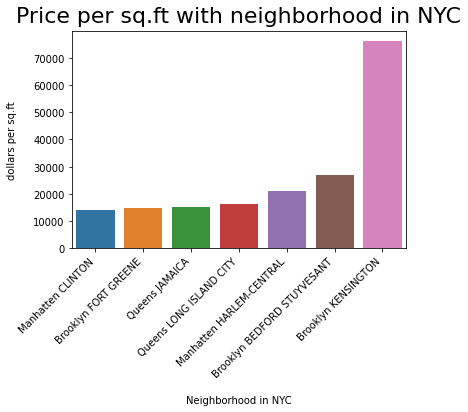

In [125]:
neighborhood_data=df3.filter(df3.price_per_sq_ft >=10000).\
                                            groupby('NEIGHBORHOOD','borough').avg('price_per_sq_ft')
neighborhood_pd=neighborhood_data.withColumn("neigbor", concat_ws(" ",  neighborhood_data.borough,neighborhood_data.NEIGHBORHOOD)).\
                                  toPandas().sort_values('avg(price_per_sq_ft)')
sns.barplot(x = 'neigbor',
            y='avg(price_per_sq_ft)',
              data=neighborhood_pd
)
plt.ylabel("dollars per sq.ft", labelpad=16)

plt.xlabel("Neighborhood in NYC", labelpad=16)
plt.title("Price per sq.ft with neighborhood in NYC", y=1.013, fontsize=22)
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
)
plt.show()

## zhu

In [ ]:
nyc_sales_df=nyc_rolling_sales_df
nyc_pd = nyc_sales_df.toPandas()
nyc_pd['BUILDING CLASS AT TIME OF SALE'].unique()
print(len(nyc_pd['BUILDING CLASS AT TIME OF SALE'].unique()))
nyc_pd['BUILDING CLASS AT TIME OF SALE'].unique()

166


array(['C2', 'C7', 'C4', 'D5', 'D9', 'D7', 'D1', 'C6', 'D0', 'D4', 'RR',
       'R2', 'R4', 'S3', 'S4', 'S5', 'R1', 'R8', 'R9', 'K4', 'M9', 'M3',
       'RA', 'RK', 'RS', 'A9', 'A4', 'B3', 'B1', 'S2', 'C0', 'R6', 'C5',
       'C3', 'C1', 'D6', 'S9', 'O2', 'O1', 'O3', 'O5', 'O6', 'K1', 'K2',
       'L9', 'L8', 'L1', 'H1', 'H8', 'H3', 'R5', 'G9', 'G6', 'P7', 'M1',
       'N2', 'RB', 'RG', 'RT', 'K9', 'V1', 'GW', 'G2', 'I7', 'M4', 'Z9',
       'B9', 'D3', 'I9', 'U6', 'O4', 'L3', 'H2', 'E1', 'Z3', 'Q1', 'RW',
       'C9', 'J5', 'N9', 'S1', 'A5', 'J8', 'B2', 'C8', 'F5', 'G7', 'G5',
       'G4', 'P2', 'Q9', 'Y1', 'RP', 'O8', 'HR', 'G1', 'E7', 'I5', 'R3',
       'I4', 'H9', 'RH', 'D8', 'HB', 'J4', 'W2', 'P9', 'A7', 'D2', 'S0',
       'O7', 'O9', 'W3', 'HS', 'H6', 'J9', 'R0', 'HH', 'W8', 'W6', 'A1',
       'K5', 'F1', 'V9', 'A2', 'V0', 'G0', 'F4', 'E9', 'I3', 'W4', 'V3',
       'I1', 'A6', 'Q8', 'A3', 'Z0', 'W1', 'U1', 'F2', 'F9', 'GU', 'I6',
       'G8', 'P5', 'Y3', 'W9', 'M2', 'G3', 'V6', 'K

In [ ]:
plt_df = nyc_sales_df.groupby('BUILDING CLASS AT TIME OF SALE').agg(avg('SALE PRICE'),count("*"))
plt_df.show()

+------------------------------+--------------------+--------+
|BUILDING CLASS AT TIME OF SALE|     avg(SALE PRICE)|count(1)|
+------------------------------+--------------------+--------+
|                            Z9|  2975358.5112781953|     151|
|                            RG|  120983.41301059001|    1120|
|                            C6|    478098.674600078|    2760|
|                            A9|   533994.4361785435|    1414|
|                            H6|             7.535E7|       2|
|                            D5|         2.5389327E7|      24|
|                            D7|2.1996417849056605E7|      66|
|                            R6|          988958.155|     204|
|                            W6|                 0.0|       2|
|                            V3|  16833.333333333332|       9|
|                            F2|           2618750.0|       6|
|                            R8|  2361951.0126582277|      96|
|                            RA|        1.93206434E7|  

Text(0.5, 1.0, 'average sale price of building class')

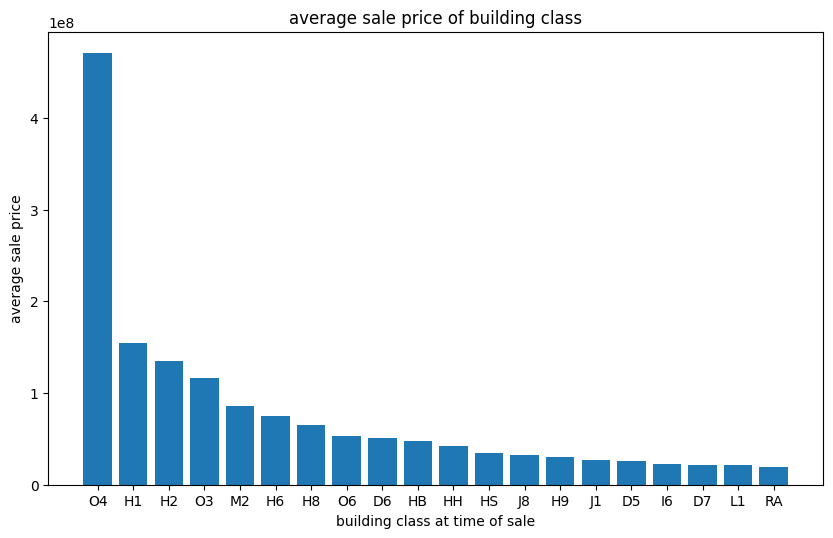

In [ ]:

df1 = plt_df.orderBy('avg(SALE PRICE)', ascending = False)
plt1 = df1.toPandas()
plt1_20 = plt1.head(20)
plt.figure(num=None, figsize=(10, 6), dpi = 100)
plt.bar(x = 'BUILDING CLASS AT TIME OF SALE', height = 'avg(SALE PRICE)', data = plt1_20)
plt.ylabel('average sale price')
plt.xlabel('building class at time of sale')
plt.title('average sale price of building class')

Text(0.5, 1.0, 'total number of sold building by building class')

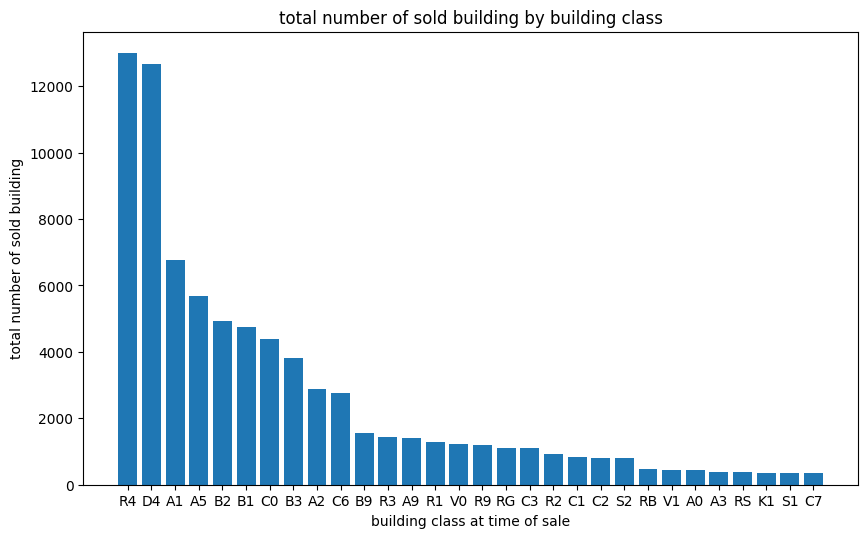

In [ ]:
df2 = plt_df.orderBy('count(1)', ascending = False)
plt2 = df2.toPandas()
plt2_30 = plt2.head(30)
plt.figure(num=None, figsize=(10, 6), dpi = 100)
plt.bar(x = 'BUILDING CLASS AT TIME OF SALE', height = 'count(1)', data = plt2_30)
plt.ylabel('total number of sold building')
plt.xlabel('building class at time of sale')
plt.title('total number of sold building by building class')

## LinearRegression

In [ ]:
nyc_property_df = nyc_rolling_sales_df.withColumn("LAND SQUARE FEET", nyc_rolling_sales_df["LAND SQUARE FEET"].cast(IntegerType()))
nyc_property_df = nyc_property_df.withColumn("GROSS SQUARE FEET", nyc_property_df["GROSS SQUARE FEET"].cast(IntegerType()))
nyc_property_df = nyc_property_df.withColumn("SALE PRICE", nyc_property_df["SALE PRICE"].cast(IntegerType()))

In [ ]:

columns = ['BOROUGH', 'BUILDING CLASS CATEGORY', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'SALE PRICE']
nyc_property_df_1 = nyc_property_df.select(columns)

nyc_property_df_1 = nyc_property_df_1.filter(((col('RESIDENTIAL UNITS') > 0) | (col('COMMERCIAL UNITS') > 0)) & \
                                             (col('GROSS SQUARE FEET') > 0) & (col('SALE PRICE') > 50) & \
                                             (col('YEAR BUILT') > 1600) &\
                                             (col('LAND SQUARE FEET') > 100))
nyc_property_df_1 = nyc_property_df_1.withColumn('BUILDING AGE', 2020-col('YEAR BUILT')).drop("YEAR BUILT")

In [ ]:
import pyspark.sql.functions as F 
borough_catag = list(nyc_property_df_1.select('BOROUGH').distinct().toPandas()['BOROUGH'])
borough_dummy = [F.when(F.col('BOROUGH') == cata,1).otherwise(0)\
            .alias("BOROUGH_" + str(cata)) for cata in borough_catag]
class_catag = list(nyc_property_df_1.select('BUILDING CLASS CATEGORY').distinct().toPandas()['BUILDING CLASS CATEGORY'])
class_dummy = [F.when(F.col('BUILDING CLASS CATEGORY') == cata,1).otherwise(0)\
            .alias("CLASS_" + str(cata)[:2]) for cata in class_catag]
nyc_property_df_2 = nyc_property_df_1.select(borough_dummy+class_dummy+nyc_property_df_1.columns)
boroughs = nyc_property_df_2.columns[:5]
for i in range(5):
  nyc_property_df_2 = nyc_property_df_2.withColumn(boroughs[i]+"*"+"LAND SQUARE FEET", col(boroughs[i])*col("LAND SQUARE FEET"))
  nyc_property_df_2 = nyc_property_df_2.withColumn(boroughs[i]+"*"+"GROSS SQUARE FEET", col(boroughs[i])*col("GROSS SQUARE FEET"))

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
nyc_property_train_df, nyc_property_test_df = nyc_property_df_2.randomSplit([0.7, 0.3])

featureCols = nyc_property_df_2.columns
featureCols = [n for n in featureCols if n not in ['BOROUGH','BUILDING CLASS CATEGORY', 'SALE PRICE']]
va = VectorAssembler(inputCols=featureCols, outputCol="features")

lr = LinearRegression(featuresCol = 'features', labelCol='SALE PRICE')

nyc_property_pipe = Pipeline(stages= [va, lr])
nyc_property_model = nyc_property_pipe.fit(nyc_property_train_df)
nyc_property_predictions = nyc_property_model.transform(nyc_property_test_df)
price_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="SALE PRICE", metricName="mse")
price_error = price_evaluator.evaluate(nyc_property_predictions)
print("Mean Squared Error (MSE) on test data = %g" % price_error)

Mean Squared Error (MSE) on test data = 7.31637e+13


(0.0, 100000000.0)

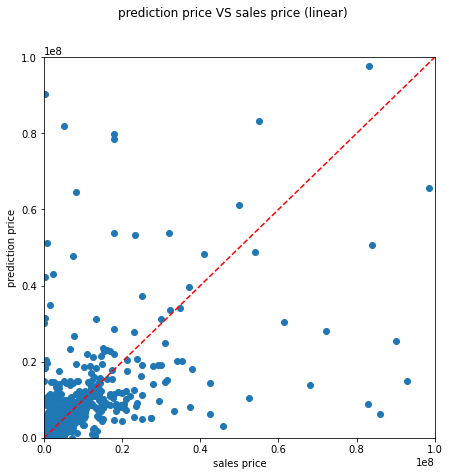

In [ ]:
sales_price = list(nyc_property_predictions.select('SALE PRICE').toPandas()['SALE PRICE'])
prediction_price = list(nyc_property_predictions.select('prediction').toPandas()['prediction'])
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(7)
ax.plot([0, 100000000], [0, 100000000], 'r--')
ax.scatter(sales_price,prediction_price)

fig.suptitle("prediction price VS sales price (linear)")
ax.set_xlabel("sales price")
ax.set_ylabel("prediction price")
plt.xlim(0, 100000000)
plt.ylim(0, 100000000)

## Random forest






































In [ ]:
featureCols_del = ['BOROUGH', 'BUILDING CLASS CATEGORY'] + nyc_property_train_df.columns[-10:]
featureCols_2 = [n for n in featureCols if n not in featureCols_del]
featureCols_3 = featureCols_2 + ['SALE PRICE']
nyc_property_train_df_1 = nyc_property_train_df.select(featureCols_3)
nyc_property_test_df_1 = nyc_property_test_df.select(featureCols_3)
va_1 = VectorAssembler(inputCols=featureCols_2, outputCol="features")
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

rfr = RandomForestRegressor(labelCol="SALE PRICE", featuresCol="features", maxDepth = 20)
random_pipeline = Pipeline(stages=[va_1, rfr])
random_model = random_pipeline.fit(nyc_property_train_df_1)
random_prediction = random_model.transform(nyc_property_test_df_1)

In [ ]:
price_error_1 = price_evaluator.evaluate(random_prediction)
print("Mean Squared Error (MSE) on test data = %g" % price_error_1)

Mean Squared Error (MSE) on test data = 3.33756e+13


(0.0, 100000000.0)

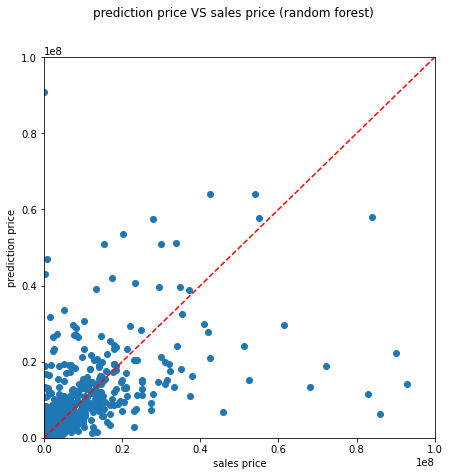

In [ ]:
sales_price_1 = list(random_prediction.select('SALE PRICE').toPandas()['SALE PRICE'])
prediction_price_1 = list(random_prediction.select('prediction').toPandas()['prediction'])

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(7)
ax.plot([0, 100000000], [0, 100000000], 'r--')
ax.scatter(sales_price_1,prediction_price_1)

fig.suptitle("prediction price VS sales price (random forest)")
ax.set_xlabel("sales price")
ax.set_ylabel("prediction price")
plt.xlim(0, 100000000)
plt.ylim(0, 100000000)

## GBT MODEL

In [ ]:



# preprocessing
df2 = nyc_rolling_sales_df.dropna(thresh=3,subset=('SALE PRICE', 'BUILDING CLASS CATEGORY', 'YEAR BUILT'))
df2 = df2.withColumn('SALE PRICE', translate('SALE PRICE', '-', '0'))
df2=df2.withColumnRenamed('SALE PRICE', 'price')
df2=df2.where("price!=0")
from pyspark.sql.types import FloatType
df2 = df2.withColumn('TOTAL UNITS', df2['TOTAL UNITS'].cast(FloatType()))
df2 = df2.withColumn('LAND SQUARE FEET', df2['LAND SQUARE FEET'].cast(FloatType()))
df2 = df2.withColumn('GROSS SQUARE FEET', df2['GROSS SQUARE FEET'].cast(FloatType()))
df2 = df2.withColumn('YEAR BUILT', df2['YEAR BUILT'].cast(FloatType()))
df2 = df2.withColumn('price', df2['price'].cast(FloatType()))
df2 = df2.dropna(thresh=5,subset=('TOTAL UNITS', 'LAND SQUARE FEET',	'GROSS SQUARE FEET',	'YEAR BUILT', 'price'))

Pipeline

In [ ]:
train, test = df2.randomSplit([8.0, 2.0])

va = feature.VectorAssembler(inputCols=['TOTAL UNITS', 'LAND SQUARE FEET',	'GROSS SQUARE FEET',	'YEAR BUILT'], outputCol='features')
gbt = regression.GBTRegressor(featuresCol='features', labelCol='price', maxIter=50, maxDepth=10, seed=42)

pipe = Pipeline(stages=[va, gbt])

model_gbt = pipe.fit(train)
gbt_prediction = model_gbt.transform(test)


In [ ]:
evaluator = evaluation.RegressionEvaluator(predictionCol='prediction', labelCol='price', metricName='mae')
evaluator.evaluate(gbt_prediction)

1162240.098897343

In [ ]:
df_stats = gbt_prediction.select(
    mean(col('price')).alias('mean')
).collect()
df_stats

[Row(mean=1460918.540472063)]

(0.0, 100000000.0)

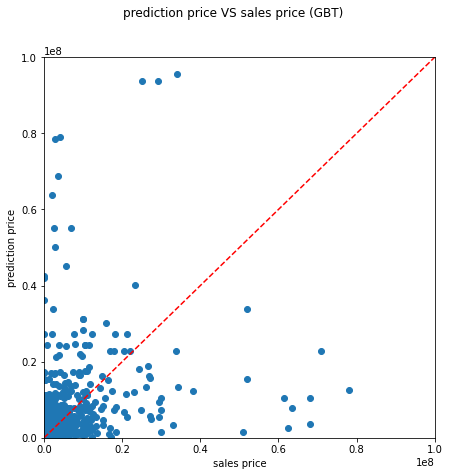

In [ ]:
import matplotlib.pyplot as plt

gbt = gbt_prediction.toPandas()

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(7)
ax.plot([0, 100000000], [0, 100000000], 'r--')
ax.scatter(gbt['price'], gbt['prediction'])

fig.suptitle("prediction price VS sales price (GBT)")
ax.set_xlabel("sales price")
ax.set_ylabel("prediction price")
plt.xlim(0, 100000000)
plt.ylim(0, 100000000)